In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [17]:
path="C:\\Users\\bachiler\\desktop\\time series\\bitcoin_data.csv"
df=pd.read_csv(path)
df.drop(columns=['Unnamed: 0'],inplace=True)

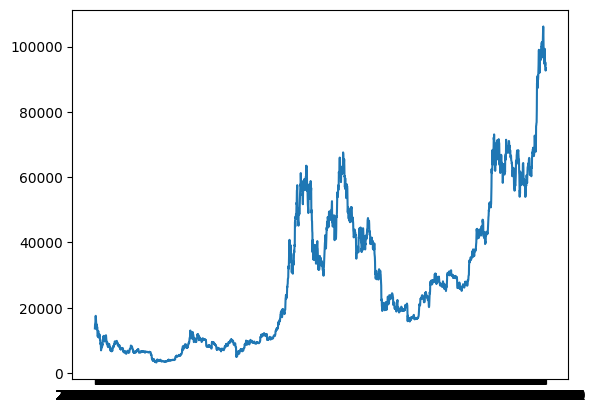

In [18]:
plt.plot(df.Date,df["Close"])

In [19]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').drop_duplicates('Date')
#df.drop(df[df['Date']<'2021-01-01'].index,inplace=True)
df.set_index('Date', inplace=True)

Text(0.5, 1.0, 'bitcoin close data')

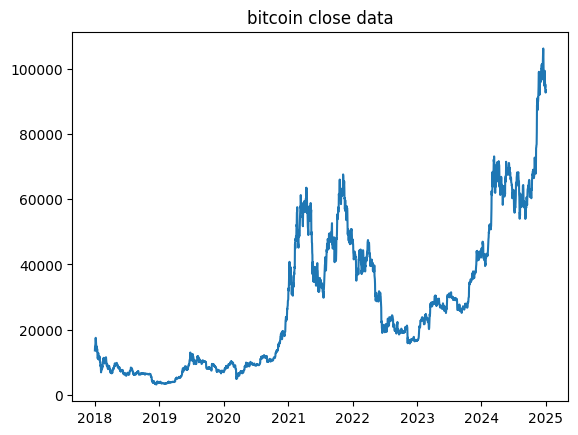

In [20]:
plt.plot(df["Close"])
plt.title('bitcoin close data')

In [21]:
from  sklearn.ensemble import IsolationForest
df['z_anom'] = (np.abs((df['Close'] - df['Close'].mean()) / df['Close'].std()) > 3).astype(int)

iso = IsolationForest(contamination=0.01)
df['iso_anom'] = (iso.fit_predict(df[['Close','High','Low','Open','Volume']]) == -1).astype(int)

df['is_anomaly'] = ((df['z_anom'] + df['iso_anom']) > 0).astype(int)
df.drop(columns=["z_anom","iso_anom"],axis=1)

,Close,High,Low,Open,Volume,is_anomaly
Date,,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000,0
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192,0
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160,0
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744,0
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072,0
...,...,...,...,...,...,...
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,0
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,1
2024-12-29,93530.226562,95174.875000,92881.789062,95174.054688,29635885267,0


In [22]:
lags = [1, 2, 3, 7, 14, 21, 30]   # strong for crypto

for lag in lags:
    df[f"return_lag_{lag}"] = df["Close"].shift(lag)

df = df.dropna()
df['Close_roll_7'] = df['Close'].rolling(7).mean()
df['Vol_roll_7'] = df['Volume'].rolling(7).mean()
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day


    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X
create_features(df)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Date,,,,,,,
2018-01-31,0,2,1,1,2018,31,31
2018-02-01,0,3,1,2,2018,32,1
2018-02-02,0,4,1,2,2018,33,2
2018-02-03,0,5,1,2,2018,34,3
2018-02-04,0,6,1,2,2018,35,4
...,...,...,...,...,...,...,...
2024-12-27,0,4,4,12,2024,362,27
2024-12-28,0,5,4,12,2024,363,28
2024-12-29,0,6,4,12,2024,364,29


In [23]:
df["target"]=df.Close.shift(-1)
df.dropna(inplace=True)
df

,Close,High,Low,Open,Volume,z_anom,iso_anom,is_anomaly,return_lag_1,return_lag_2,...,Vol_roll_7,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,target
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-06,7754.000000,7850.700195,6048.259766,7051.750000,13999800320,0,0,0,6955.270020,8277.009766,...,9.764270e+09,2018-02-06,0,1,1,2,2018,37,6,7621.299805
2018-02-07,7621.299805,8509.110352,7236.790039,7755.490234,9169280000,0,0,0,7754.000000,6955.270020,...,9.925430e+09,2018-02-07,0,2,1,2,2018,38,7,8265.589844
2018-02-08,8265.589844,8558.769531,7637.859863,7637.859863,9346750464,0,0,0,7621.299805,7754.000000,...,9.837909e+09,2018-02-08,0,3,1,2,2018,39,8,8736.980469
2018-02-09,8736.980469,8736.980469,7884.709961,8271.839844,6784820224,0,0,0,8265.589844,7621.299805,...,8.989040e+09,2018-02-09,0,4,1,2,2018,40,9,8621.900391
2018-02-10,8621.900391,9122.549805,8295.469727,8720.080078,7780960256,0,0,0,8736.980469,8265.589844,...,9.062922e+09,2018-02-10,0,5,1,2,2018,41,10,8129.970215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,1,0,1,99299.195312,98676.093750,...,5.623668e+10,2024-12-26,0,3,4,12,2024,361,26,94164.859375
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,0,0,0,95795.515625,99299.195312,...,4.863465e+10,2024-12-27,0,4,4,12,2024,362,27,95163.929688
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,1,0,1,94164.859375,95795.515625,...,4.468353e+10,2024-12-28,0,5,4,12,2024,363,28,93530.226562


In [24]:
df.drop(columns=["z_anom","iso_anom"],axis=1)

,Close,High,Low,Open,Volume,is_anomaly,return_lag_1,return_lag_2,return_lag_3,return_lag_7,...,Vol_roll_7,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,target
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-06,7754.000000,7850.700195,6048.259766,7051.750000,13999800320,0,6955.270020,8277.009766,9174.910156,10106.299805,...,9.764270e+09,2018-02-06,0,1,1,2,2018,37,6,7621.299805
2018-02-07,7621.299805,8509.110352,7236.790039,7755.490234,9169280000,0,7754.000000,6955.270020,8277.009766,10221.099609,...,9.925430e+09,2018-02-07,0,2,1,2,2018,38,7,8265.589844
2018-02-08,8265.589844,8558.769531,7637.859863,7637.859863,9346750464,0,7621.299805,7754.000000,6955.270020,9170.540039,...,9.837909e+09,2018-02-08,0,3,1,2,2018,39,8,8736.980469
2018-02-09,8736.980469,8736.980469,7884.709961,8271.839844,6784820224,0,8265.589844,7621.299805,7754.000000,8830.750000,...,8.989040e+09,2018-02-09,0,4,1,2,2018,40,9,8621.900391
2018-02-10,8621.900391,9122.549805,8295.469727,8720.080078,7780960256,0,8736.980469,8265.589844,7621.299805,9174.910156,...,9.062922e+09,2018-02-10,0,5,1,2,2018,41,10,8129.970215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,1,99299.195312,98676.093750,94686.242188,97490.953125,...,5.623668e+10,2024-12-26,0,3,4,12,2024,361,26,94164.859375
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,0,95795.515625,99299.195312,98676.093750,97755.929688,...,4.863465e+10,2024-12-27,0,4,4,12,2024,362,27,95163.929688
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,1,94164.859375,95795.515625,99299.195312,97224.726562,...,4.468353e+10,2024-12-28,0,5,4,12,2024,363,28,93530.226562


In [25]:
def train_test_split(data,test_percent):
    data=data.values
    n=int(len(data)*(1-test_percent))
    return data[:n],data[n:]

In [26]:
df["date"]=df["date"].view("int64")

C:\Users\bachiler\AppData\Local\Temp\ipykernel_6976\2701299260.py:1: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["date"]=df["date"].view("int64")


In [27]:
train,test=train_test_split(df,0.2)

In [28]:
#df=df.reset_index(drop=True)

In [29]:
x=train[:,:-1]
y=train[:,-1]

In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
params={"max_depth":[3,6],
        "learning_rate":[0.05],
       "n_estimators":[700,1000],
       "colsample_bytree":[0.3,0.7]}
xgbr=XGBRegressor(seed=20)
modl=GridSearchCV(estimator=xgbr,param_grid=params,scoring="neg_mean_squared_error",verbose=1)

In [31]:
train

array([[7.75400000e+03, 7.85070020e+03, 6.04825977e+03, ...,
        3.70000000e+01, 6.00000000e+00, 7.62129980e+03],
       [7.62129980e+03, 8.50911035e+03, 7.23679004e+03, ...,
        3.80000000e+01, 7.00000000e+00, 8.26558984e+03],
       [8.26558984e+03, 8.55876953e+03, 7.63785986e+03, ...,
        3.90000000e+01, 8.00000000e+00, 8.73698047e+03],
       ...,
       [2.94159648e+04, 2.94651133e+04, 2.93575879e+04, ...,
        2.24000000e+02, 1.20000000e+01, 2.92829141e+04],
       [2.92829141e+04, 2.94414336e+04, 2.92658066e+04, ...,
        2.25000000e+02, 1.30000000e+01, 2.94084434e+04],
       [2.94084434e+04, 2.96602539e+04, 2.91241055e+04, ...,
        2.26000000e+02, 1.40000000e+01, 2.91703477e+04]], shape=(2016, 26))

In [32]:
df.dtypes

Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
z_anom             int64
iso_anom           int64
is_anomaly         int64
return_lag_1     float64
return_lag_2     float64
return_lag_3     float64
return_lag_7     float64
return_lag_14    float64
return_lag_21    float64
return_lag_30    float64
Close_roll_7     float64
Vol_roll_7       float64
date               int64
hour               int32
dayofweek          int32
quarter            int32
month              int32
year               int32
dayofyear          int32
dayofmonth         int32
target           float64
dtype: object

In [33]:
#df["date"]=pd.to_datetime(df["date"])
#df["date"]=df["date"].view("int64")

In [34]:
df.head()

,Close,High,Low,Open,Volume,z_anom,iso_anom,is_anomaly,return_lag_1,return_lag_2,...,Vol_roll_7,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,target
0,7754.000000,7850.700195,6048.259766,7051.750000,13999800320,0,0,0,6955.270020,8277.009766,...,9.764270e+09,1517875200000000000,0,1,1,2,2018,37,6,7621.299805
1,7621.299805,8509.110352,7236.790039,7755.490234,9169280000,0,0,0,7754.000000,6955.270020,...,9.925430e+09,1517961600000000000,0,2,1,2,2018,38,7,8265.589844
2,8265.589844,8558.769531,7637.859863,7637.859863,9346750464,0,0,0,7621.299805,7754.000000,...,9.837909e+09,1518048000000000000,0,3,1,2,2018,39,8,8736.980469
3,8736.980469,8736.980469,7884.709961,8271.839844,6784820224,0,0,0,8265.589844,7621.299805,...,8.989040e+09,1518134400000000000,0,4,1,2,2018,40,9,8621.900391
4,8621.900391,9122.549805,8295.469727,8720.080078,7780960256,0,0,0,8736.980469,8265.589844,...,9.062922e+09,1518220800000000000,0,5,1,2,2018,41,10,8129.970215


In [35]:
#df=df.reset_index(drop=True)
df.index

RangeIndex(start=0, stop=2520, step=1)

In [36]:
modl.fit(x,y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.3, 0.7], 'learning_rate': [0.05], 'max_depth': [3, 6], 'n_estimators': [700, 1000]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,None
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [37]:
print("best parameter",modl.best_params_)
print("lowest rmse ",(-modl.best_score_)**(1/2.0))

best parameter {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 700}
lowest rmse  1777.4651293257516


In [38]:
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.7,
    objective="reg:squarederror"
)
model.fit(x,y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [39]:
val=np.array(test[0,:-1]).reshape(1,-1)
pred=model.predict(val)
pred

array([28898.178], dtype=float32)

In [40]:
def xgb_predict(train,val):
    train=np.array(train)
    x,y=train[:,:-1],train[:,-1]
    model = XGBRegressor(
         n_estimators=700,
         learning_rate=0.05,
         max_depth=3,
         subsample=0.8,
         colsample_bytree=0.7,
         objective="reg:squarederror"
          )
    model.fit(x,y)
    val=np.array(val).reshape(1,-1)
    pred=model.predict(val)
    return pred[0]
xgb_predict(train,test[0,:-1])

np.float32(28898.178)

In [41]:
def mape(actual,pred):
    actual,pred=np.array(actual),np.array(pred)
    mape=np.mean(np.abs((actual-pred)/actual))*100
    return mape

In [42]:
from sklearn.metrics import mean_squared_error
def validate(data,perc):
    predictions =[]
   
    train,test=train_test_split(data,perc)
   
    history=[x for x in train]
    for i in range(len(test)):
        x_test,y_test=test[i,:-1],test[i,-1]
        pred=xgb_predict(history,x_test)
        predictions.append(pred)
        history.append(test[i])
    mse=mean_squared_error(test[:,-1],predictions)
    error=np.sqrt(mse)
    MAPE=mape(test[:,-1],predictions)
    return error,MAPE,test[:,-1],predictions


In [43]:
rmse,mape,y,pred=validate(df,0.2)

In [86]:
#pred

In [44]:
print("rmse "f"{rmse}")
print("mape "f"{mape}")
#print(y)
#print(pred)

rmse1934.5873236697948
mape2.1892919695091453


In [45]:
pred=np.array(pred)
test_pred=np.c_[test,pred]


In [46]:
df_tp=pd.DataFrame(test_pred,columns=["Close","High","Low","Open","Volume","z_anom","iso_anom","is_anomaly","return_lag_1",
                                      "return_lag_2","return_lag_3","return_lag_7","return_lag_14","return_lag_21","return_lag_30",
                                      "Close_roll_7","Vol_roll_7","date","hour","dayofweek","quarter","month","year","dayofyear",
                                      "dayofmonth","target","xgb_prediction"])

Text(0, 0.5, 'closing price in USD $')

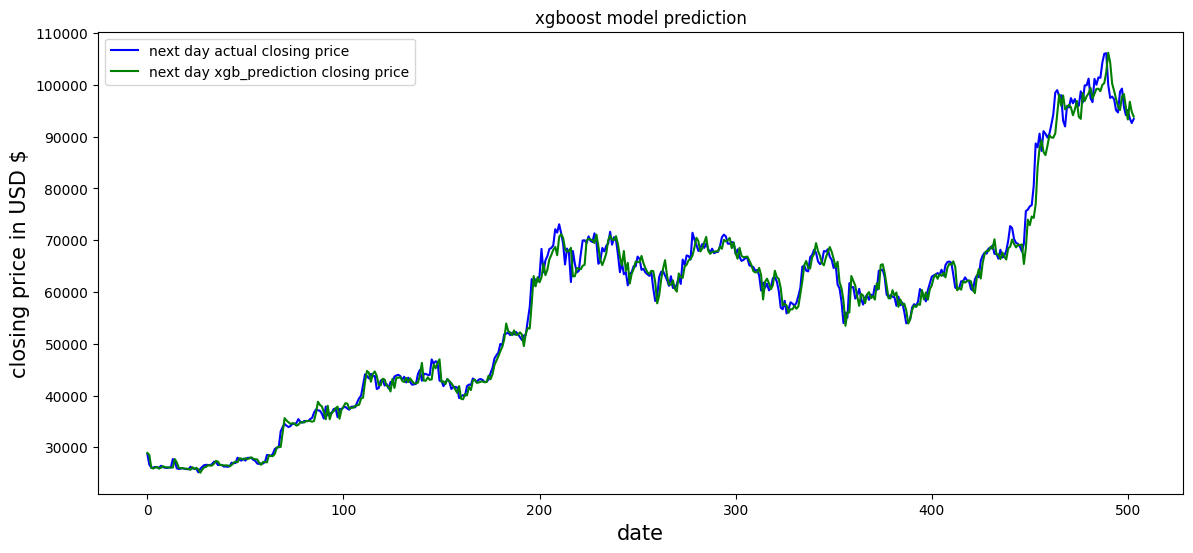

In [47]:
plt.figure(figsize=(14,6))
plt.title("xgboost model prediction")
plt.plot(df_tp["target"],label="next day actual closing price",color="blue")
plt.plot(df_tp["xgb_prediction"],label="next day xgb_prediction closing price",color="green")
plt.xlabel("date",fontsize=15)
plt.legend(loc="upper left")
plt.ylabel("closing price in USD $",fontsize=15)